<a href="https://colab.research.google.com/github/muhammad-usama-aleem/3D-Transform-social-media-icon/blob/master/CIFAR_10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **download kaggle data in Google Colab**

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


In [2]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         66           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         90           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        825           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        159           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1790           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13822           False  
house-pr

In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:08<00:00, 38.1MB/s]
100% 346M/346M [00:08<00:00, 43.6MB/s]


In [ ]:
!unzip /content/intel-image-classification.zip

In [5]:
# removing zip file
!rm -rf /content/intel-image-classification.zip

# **Importing Libraies**

In [6]:
import tensorflow as tf
import time

# use this command to allow growth of the memory and this prevent error.
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# if error is 'Physical error cannot be modified after being initailized', then restart kernel.

# **Load Data**

In [7]:
from tensorflow.keras import datasets

# importing cfiar dataset 
# (train_x, train_y), (test_x, test_y) = datasets.cifar10.load_data()

# **Preprocessing**

In [8]:
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

In [9]:
TRAIN_DIR = "/content/seg_train/seg_train"

In [10]:
# splitting into train and validation 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15, # seprating 15% of train dataset for validation 
    subset='training',
    seed=124, # give any non negative number to split the dataset into valid and split
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15,
    subset='validation',
    seed=124,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

Found 14034 files belonging to 6 classes.
Using 11929 files for training.
Found 14034 files belonging to 6 classes.
Using 2105 files for validation.


In [11]:
class_names = train_data.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# **Visualizing data set**

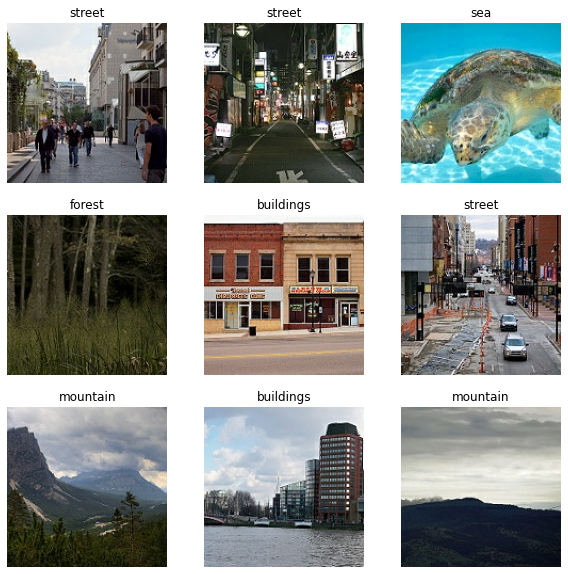

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# **Model**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import layers, regularizers

num_classes = 6

model = Sequential([
  # first layer is used for normalization
  layers.RandomFlip("horizontal", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [17]:
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

start = time.time()
resp = model.fit(train_data, 
          epochs=5, 
          batch_size=25,
          callbacks=[tensorboard_callback])
stop = time.time()

Epoch 1/5
373/373 [==============================] - 15s 40ms/step - loss: 1.1617 - accuracy: 0.5802
Epoch 2/5
373/373 [==============================] - 15s 40ms/step - loss: 0.9621 - accuracy: 0.6716
Epoch 3/5
373/373 [==============================] - 15s 40ms/step - loss: 0.9178 - accuracy: 0.6881
Epoch 4/5
373/373 [==============================] - 14s 38ms/step - loss: 0.8359 - accuracy: 0.7279
Epoch 5/5
373/373 [==============================] - 14s 37ms/step - loss: 0.8231 - accuracy: 0.7352


In [18]:
print(f"Training time: {stop - start}s")

Training time: 78.59072256088257s


In [22]:
!tensorboard --logdir /content/logs/fit


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)



CTRL+C




.'
^C


In [ ]:
dir(resp)

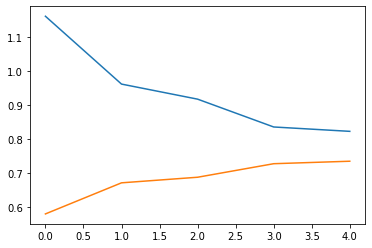

In [19]:
# plot accuracy and loss w.r.t epoch

import matplotlib.pyplot as plt


plt.plot(resp.epoch, resp.history['loss'])
plt.plot(resp.epoch, resp.history['accuracy'])

plt.show()

# **Evaluation**

In [22]:
model.evaluate(val_data)

66/66 [==============================] - 4s 33ms/step - loss: 0.7361 - accuracy: 0.7620


[0.7361153960227966, 0.761995255947113]

In [27]:
results = model.predict(val_data)

# **Save Model**

In [ ]:
model.save("inetlenv")

INFO:tensorflow:Assets written to: inetlenv/assets


# **Load Model**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np


my_model = tf.keras.models.load_model("/content/inetlenv")

image = cv2.imread(TRAIN_DIR + "/forest/8.jpg")
resp = model.predict(np.expand_dims(image, axis=0))
class_names[np.argmax(resp)]

'forest'

In [24]:
# get label from valid_folder

orignal = []
for img, label in val_data:
  orignal.extend([int(val) for val in label])
print(orignal)

[0, 2, 0, 0, 0, 2, 4, 2, 2, 1, 5, 1, 3, 3, 3, 4, 3, 0, 0, 4, 0, 0, 2, 0, 5, 3, 5, 1, 2, 3, 4, 1, 4, 3, 2, 4, 3, 2, 2, 5, 2, 0, 2, 5, 5, 5, 3, 0, 0, 1, 5, 4, 5, 4, 2, 3, 1, 3, 5, 4, 1, 1, 3, 4, 0, 1, 4, 4, 5, 5, 4, 3, 3, 1, 5, 1, 0, 3, 3, 0, 3, 1, 4, 3, 1, 2, 3, 2, 2, 4, 4, 5, 0, 1, 3, 5, 3, 4, 0, 1, 0, 3, 4, 5, 4, 4, 3, 3, 4, 4, 0, 4, 2, 1, 2, 4, 2, 0, 4, 5, 5, 5, 2, 0, 2, 5, 5, 5, 3, 4, 3, 1, 4, 3, 1, 2, 4, 4, 5, 3, 0, 1, 5, 4, 1, 1, 4, 0, 3, 3, 3, 0, 4, 1, 3, 2, 1, 2, 1, 2, 1, 0, 2, 5, 1, 4, 5, 5, 0, 2, 0, 4, 3, 5, 1, 5, 1, 4, 5, 3, 3, 0, 4, 1, 0, 0, 4, 4, 1, 2, 0, 4, 3, 0, 0, 5, 2, 4, 4, 1, 3, 4, 4, 1, 5, 2, 2, 0, 5, 0, 4, 2, 5, 3, 3, 1, 5, 2, 1, 3, 2, 1, 3, 1, 4, 5, 0, 2, 4, 3, 4, 5, 1, 1, 4, 2, 5, 1, 4, 3, 5, 4, 5, 3, 5, 0, 3, 4, 4, 5, 4, 3, 2, 5, 4, 5, 3, 3, 0, 1, 2, 1, 4, 3, 0, 0, 3, 4, 4, 2, 0, 4, 4, 1, 2, 2, 1, 5, 1, 4, 3, 0, 3, 5, 3, 3, 3, 1, 4, 3, 5, 2, 4, 1, 4, 1, 3, 4, 4, 4, 5, 0, 5, 3, 3, 2, 3, 3, 1, 0, 1, 3, 0, 3, 4, 4, 3, 3, 3, 1, 5, 0, 0, 1, 4, 3, 3, 4, 0, 3, 2, 4, 2, 

In [28]:
import numpy as np
predictions = [np.argmax(cls) for cls in results]

In [32]:
from sklearn import metrics
resp = metrics.confusion_matrix(predictions, orignal)

In [33]:
import pandas as pd
df_cm = pd.DataFrame(resp, columns=class_names, index=class_names)
df_cm

,buildings,forest,glacier,mountain,sea,street
buildings,243,7,18,33,19,68
forest,9,334,3,1,5,18
glacier,5,1,240,51,14,2
mountain,2,1,26,213,6,1
sea,12,1,61,77,310,9
street,30,9,5,3,4,264


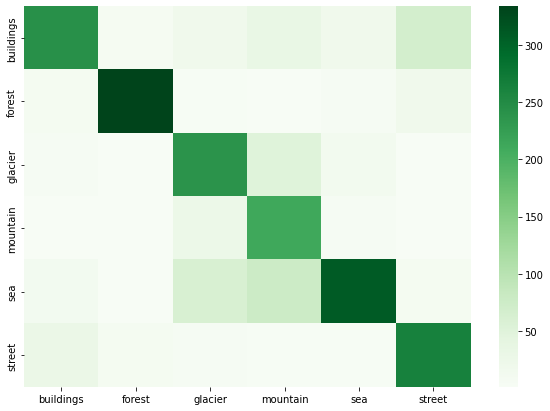

In [34]:
import seaborn as sns


plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, cmap='Greens')